In [1]:
# Core PyTorch utilities
!pip install -q torchinfo torchview torchmetrics graphviz

# System dependency for graphviz (needed for SVG rendering)
!apt-get install -y graphviz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 14.4 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [2]:
import os

KAGGLE_USERNAME = "icdar pytorch"
KAGGLE_KEY = "KGAT_b08f085f57433fcea05687ada681f387"

In [3]:
import os
os.environ["KAGGLE_USERNAME"] = "icdar pytorch"
os.environ["KAGGLE_KEY"] = "KGAT_b08f085f57433fcea05687ada681f387"

print("KAGGLE_USERNAME set:", "KAGGLE_USERNAME" in os.environ)
print("KAGGLE_KEY set:", "KAGGLE_KEY" in os.environ)


KAGGLE_USERNAME set: True
KAGGLE_KEY set: True


In [4]:
!pip install -q kaggle h5py torch torchvision torchmetrics tqdm seaborn matplotlib scikit-learn


In [5]:
import h5py
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassPrecision,
    MulticlassRecall,
    MulticlassAUROC
)

from kaggle.api.kaggle_api_extended import KaggleApi

sns.set_style("darkgrid")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [6]:
from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassPrecision,
    MulticlassRecall,
    MulticlassF1Score,
    MulticlassAUROC,
    MulticlassMatthewsCorrCoef
)
from torchinfo import summary
from torchview import draw_graph

In [7]:
import json
import os

os.makedirs("/root/.config/kaggle", exist_ok=True)

kaggle_json_path = "/root/.config/kaggle/kaggle.json"

with open(kaggle_json_path, "w") as f:
    json.dump({
        "username": os.environ["KAGGLE_USERNAME"],
        "key": os.environ["KAGGLE_KEY"]
    }, f)

os.chmod(kaggle_json_path, 0o600)

print("kaggle.json created at:", kaggle_json_path)


kaggle.json created at: /root/.config/kaggle/kaggle.json


In [8]:
from kaggle.api.kaggle_api_extended import KaggleApi
# =========================
# KAGGLE DATASET DOWNLOAD
# =========================
DATA_DIR = "brain_tumor_44c"
DATASET = "fernando2rad/brain-tumor-mri-images-44c"

if not os.path.exists(DATA_DIR):
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files(DATASET, path=DATA_DIR, unzip=True)

print("Dataset downloaded to:", DATA_DIR)




Dataset URL: https://www.kaggle.com/datasets/fernando2rad/brain-tumor-mri-images-44c
Dataset downloaded to: brain_tumor_44c


In [9]:
import os

for root, dirs, files in os.walk(DATA_DIR):
    print(root)
    break


brain_tumor_44c


In [10]:
mat_files = []
for root, _, files in os.walk(DATA_DIR):
    for f in files:
        if f.endswith(".mat") and "cvind" not in f.lower():
            mat_files.append(os.path.join(root, f))


In [11]:
import os

for root, dirs, files in os.walk(DATA_DIR):
    print("ROOT:", root)
    print("DIRS:", dirs)
    print("FILES:", files[:5])
    break


ROOT: brain_tumor_44c
DIRS: ['Astrocitoma T1', 'Meningioma T2', 'Meningioma T1C+', '_NORMAL T1', 'Astrocitoma T1C+', 'Germinoma T1C+', 'Papiloma T1', 'Schwannoma T2', 'Ependimoma T1', 'Meduloblastoma T1', 'Oligodendroglioma T1C+', 'Oligodendroglioma T2', 'Tuberculoma T1', 'Neurocitoma T2', 'Meduloblastoma T2', '_NORMAL T2', 'Glioblastoma T2', 'Schwannoma T1C+', 'Carcinoma T2', 'Neurocitoma T1', 'Granuloma T1C+', 'Tuberculoma T1C+', 'Carcinoma T1', 'Neurocitoma T1C+', 'Oligodendroglioma T1', 'Ganglioglioma T1', 'Carcinoma T1C+', 'Astrocitoma T2', 'Germinoma T1', 'Ganglioglioma T1C+', 'Papiloma T1C+', 'Ganglioglioma T2', 'Granuloma T1', 'Meduloblastoma T1C+', 'Papiloma T2', 'Ependimoma T1C+', 'Germinoma T2', 'Meningioma T1', 'Ependimoma T2', 'Tuberculoma T2', 'Granuloma T2', 'Schwannoma T1', 'Glioblastoma T1', 'Glioblastoma T1C+']
FILES: []


In [12]:
from pathlib import Path
import pandas as pd
import os

IMAGE_EXTS = (".jpg", ".jpeg", ".png")

paths, labels = [], []

# ----------------------------------
# Collect class folders (leaf dirs)
# ----------------------------------
class_dirs = []
for root, dirs, files in os.walk(DATA_DIR):
    if any(f.lower().endswith(IMAGE_EXTS) for f in files):
        class_dirs.append(root)

class_dirs = sorted(class_dirs)

# ----------------------------------
# Create class ↔ index mapping
# ----------------------------------
class_to_idx = {
    Path(d).name: idx for idx, d in enumerate(class_dirs)
}
idx_to_class = {v: k for k, v in class_to_idx.items()}

print("Number of classes:", len(class_to_idx))

# ----------------------------------
# Build dataframe
# ----------------------------------
for root, _, files in os.walk(DATA_DIR):
    class_name = Path(root).name

    if class_name not in class_to_idx:
        continue

    label = class_to_idx[class_name]

    for f in files:
        if f.lower().endswith(IMAGE_EXTS):
            paths.append(os.path.join(root, f))
            labels.append(label)

df = pd.DataFrame({
    "image_path": paths,
    "label": labels
})

print("Total images:", len(df))
print("Class distribution:\n", df["label"].value_counts().sort_index())


Number of classes: 44
Total images: 4478
Class distribution:
 label
0     176
1     232
2     171
3      66
4     112
5      73
6      45
7      48
8      57
9      20
10     18
11     23
12     27
13     40
14     33
15     55
16     94
17     55
18     30
19     31
20     17
21     23
22     67
23     41
24    272
25    369
26    233
27    130
28    223
29    104
30     86
31     72
32     66
33     66
34    108
35     63
36    148
37    194
38    123
39     28
40     84
41     33
42    251
43    271
Name: count, dtype: int64


In [13]:
num_classes = len(class_to_idx)
print("num_classes =", num_classes)


num_classes = 44


In [14]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df,
    test_size=0.20,
    stratify=df["label"],
    random_state=42
)

train_df, val_df = train_test_split(
    train_df,
    test_size=0.20,
    stratify=train_df["label"],
    random_state=42
)

print("Train:", len(train_df))
print("Val:", len(val_df))
print("Test:", len(test_df))


Train: 2865
Val: 717
Test: 896


In [15]:
from PIL import Image

class BrainTumorDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "image_path"]
        label = self.df.loc[idx, "label"]

        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)

        return img, label


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_loader = DataLoader(
    BrainTumorDataset(train_df, transform),
    batch_size=16,
    shuffle=True
)

val_loader = DataLoader(
    BrainTumorDataset(val_df, transform),
    batch_size=16
)

test_loader = DataLoader(
    BrainTumorDataset(test_df, transform),
    batch_size=16
)



In [16]:
def apply_avg_2max_pool_to_image(img_tensor, pool_layer):
    """
    img_tensor: torch.Tensor of shape (3, H, W)
    returns pooled image resized back to original size
    """
    img = img_tensor.unsqueeze(0)  # (1, 3, H, W)

    pooled_channels = []
    for c in range(3):
        ch = img[:, c:c+1, :, :]          # (1,1,H,W)
        pooled = pool_layer(ch)           # downsampled
        pooled = torch.nn.functional.interpolate(
            pooled, size=img.shape[-2:], mode="bilinear", align_corners=False
        )
        pooled_channels.append(pooled)

    pooled_img = torch.cat(pooled_channels, dim=1)
    return pooled_img.squeeze(0)


In [17]:
def visualize_original_vs_pooled(dataset, pool_layer, num_images=3):
    """
    Shows:
    Top row    -> Original images
    Bottom row -> Avg − 2×Max pooled images
    """
    indices = random.sample(range(len(dataset)), num_images)

    plt.figure(figsize=(4 * num_images, 6))

    for i, idx in enumerate(indices):
        img, _ = dataset[idx]  # img: (3,224,224)

        pooled_img = apply_avg_2max_pool_to_image(img, pool_layer)

        # Convert to display format
        orig = img.permute(1, 2, 0).cpu().numpy()
        pooled = pooled_img.permute(1, 2, 0).cpu().numpy()

        # Normalize for display
        orig = (orig - orig.min()) / (orig.max() - orig.min() + 1e-8)
        pooled = (pooled - pooled.min()) / (pooled.max() - pooled.min() + 1e-8)

        # ---- ORIGINAL ----
        plt.subplot(2, num_images, i + 1)
        plt.imshow(orig, cmap="gray")
        plt.title("Original")
        plt.axis("off")

        # ---- POOLED ----
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(pooled, cmap="gray")
        plt.title("Avg − 2×Max pooled")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [18]:
import torch
import torch.nn as nn

class AvgTwiceMaxPooling2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.avg = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
        self.max = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        return self.avg(x) - 2 * self.max(x)


In [19]:
import random
import matplotlib.pyplot as plt

def visualize_original_vs_pooled(dataset, device, num_images=3):
    pool_layer = AvgTwiceMaxPooling2D().to(device)
    pool_layer.eval()

    indices = random.sample(range(len(dataset)), num_images)

    plt.figure(figsize=(4 * num_images, 6))

    for i, idx in enumerate(indices):
        img, _ = dataset[idx]
        img = img.to(device)

        with torch.no_grad():
            pooled_img = apply_avg_2max_pool_to_image(img, pool_layer)

        orig = img.permute(1, 2, 0).cpu().numpy()
        pooled = pooled_img.permute(1, 2, 0).cpu().numpy()

        # Normalize for display
        orig = (orig - orig.min()) / (orig.max() - orig.min() + 1e-8)
        pooled = (pooled - pooled.min()) / (pooled.max() - pooled.min() + 1e-8)

        # Original
        plt.subplot(2, num_images, i + 1)
        plt.imshow(orig, cmap="gray")
        plt.title("Original")
        plt.axis("off")

        # Pooled
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(pooled, cmap="gray")
        plt.title("Avg − 2×Max pooled")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


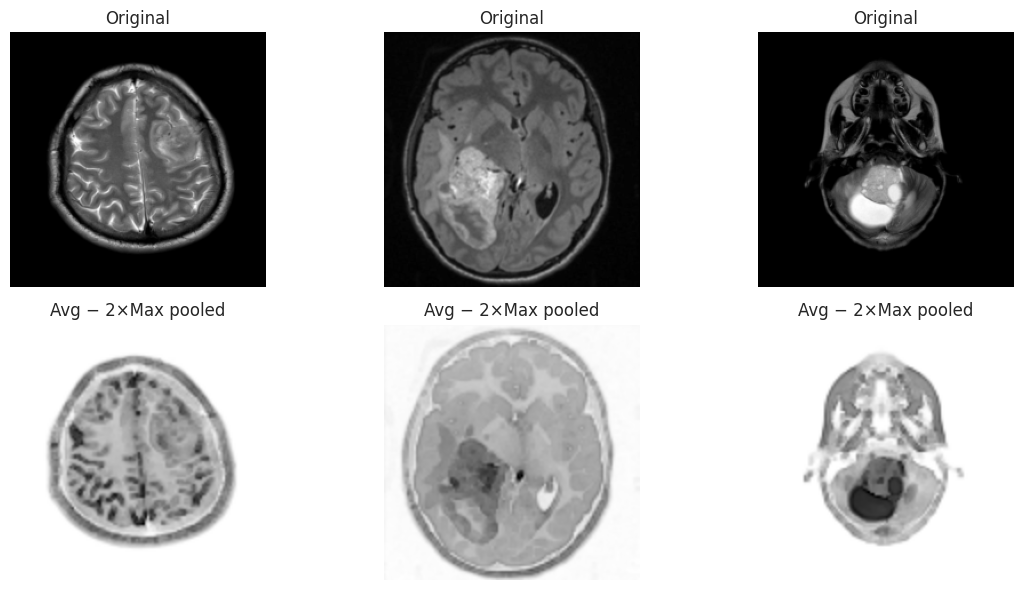

In [20]:
visualize_original_vs_pooled(
    dataset=test_loader.dataset,  # or train_loader.dataset
    device=device,
    num_images=3
)


In [21]:
# =========================
# ViT BLOCK (7×7 patch, stride=7, embed=64)
# =========================
class SimpleViT(nn.Module):
    def __init__(self, in_channels=34, embed_dim=96, num_heads=4, depth=1):
        super().__init__()

        self.patch_embed = nn.Conv2d(
            in_channels,
            embed_dim,
            kernel_size=7,
            stride=4
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            batch_first=True,
            activation="gelu"
        )

        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=depth
        )

    def forward(self, x):
        # x: (B, 55, 28, 28)
        x = self.patch_embed(x)              # (B, 64, 4, 4)
        x = x.flatten(2).transpose(1, 2)     # (B, 16, 64)
        x = self.transformer(x)              # (B, 16, 64)
        return x.mean(dim=1)                 # (B, 64)


In [22]:
import torch
import torch.nn as nn

# =========================
# MRINet
# =========================
class MRINet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # =========================
        # Early CNN layers
        # =========================
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 21, 3, padding=1),
            nn.BatchNorm2d(21),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(21, 34, 3, padding=1),
            nn.BatchNorm2d(34),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.atm = nn.Sequential(
            AvgTwiceMaxPooling2D()
        )

        # =========================
        # 55-channel block
        # =========================
        self.conv3 = nn.Sequential(
            nn.Conv2d(34, 55, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(55)
        )

        self.pool_conv_14 = nn.Sequential(
            AvgTwiceMaxPooling2D(),      # 28×28 → 14×14
            nn.Conv2d(55, 24, 3, padding=1),
            nn.GELU(),
            nn.BatchNorm2d(24)
        )

        # =========================
        # Main CNN path
        # =========================
        self.conv4 = nn.Sequential(
            nn.Conv2d(89, 89, 3, padding=1),
            nn.BatchNorm2d(89),
            nn.MaxPool2d(2)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(113, 144, 3, padding=1),
            nn.BatchNorm2d(144),
            nn.MaxPool2d(2)
        )

        self.conv6 = nn.Sequential(
            nn.Conv2d(144, 233, 3, padding=1),
            nn.Conv2d(233, 233, 3, padding=1, groups=233),
            nn.BatchNorm2d(233)
        )

        self.conv7 = nn.Sequential(
            nn.Conv2d(233, 233, 3, padding=1),
            nn.Conv2d(233, 233, 3, padding=1, groups=233),
            nn.BatchNorm2d(233)
        )

        # =========================
        # GAP for CNN branch
        # =========================
        self.gap = nn.AdaptiveAvgPool2d(1)

        # =========================
        # 55 → 21 → ViT (CLEAN)
        # =========================
        self.c2_to_vit = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False),  # 14 → 28
            nn.Conv2d(113, 55, kernel_size=3, padding=1),
            nn.BatchNorm2d(55)
        )

        self.c2_reduce_to_21 = nn.Sequential(
            nn.Conv2d(55, 21, kernel_size=1, bias=False),
            nn.BatchNorm2d(21)
        )

        self.vit = SimpleViT(
            in_channels=21,
            embed_dim=96
        )

        # =========================
        # Final classifier
        # =========================
        self.fc = nn.Linear(233 + 96, num_classes)

    def forward(self, x):
        # ---- Early layers ----
        x1 = self.conv1(x)           # (B, 21, 112, 112)
        x2 = self.conv2(x1)          # (B, 34, 56, 56)

        atm1 = self.atm(x2)          # (B, 34, 28, 28)

        # ---- 55-channel block ----
        x3 = self.conv3(x2)          # (B, 55, 28, 28)
        concat1 = torch.cat([x3, atm1], dim=1)   # (B, 89, 28, 28)

        blk = self.pool_conv_14(x3)  # (B, 24, 14, 14)

        # ---- CNN main path ----
        x4 = self.conv4(concat1)     # (B, 89, 14, 14)
        concat2 = torch.cat([x4, blk], dim=1)    # (B, 113, 14, 14)

        x5 = self.conv5(concat2)     # (B, 144, 7, 7)
        x6 = self.conv6(x5)          # (B, 233, 7, 7)
        x7 = self.conv7(x6)          # (B, 233, 7, 7)

        gap_feat = self.gap(x7).flatten(1)  # (B, 233)

        # ---- ViT path (STRICT: 55 → 21 ONLY) ----
        vit_c2 = self.c2_to_vit(concat2)         # (B, 55, 28, 28)
        vit_input = self.c2_reduce_to_21(vit_c2) # (B, 21, 28, 28)

        vit_feat = self.vit(vit_input)           # (B, 64)

        # ---- Final fusion ----
        fused = torch.cat([gap_feat, vit_feat], dim=1)
        return self.fc(fused)


In [23]:
from torchinfo import summary

model = MRINet(num_classes).to(device)

summary(
    model,
    input_size=(1, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "kernel_size"],
    depth=5
)


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Kernel Shape
MRINet                                             [1, 3, 224, 224]          [1, 44]                   --                        --
├─Sequential: 1-1                                  [1, 3, 224, 224]          [1, 21, 112, 112]         --                        --
│    └─Conv2d: 2-1                                 [1, 3, 224, 224]          [1, 21, 224, 224]         588                       [3, 3]
│    └─BatchNorm2d: 2-2                            [1, 21, 224, 224]         [1, 21, 224, 224]         42                        --
│    └─ReLU: 2-3                                   [1, 21, 224, 224]         [1, 21, 224, 224]         --                        --
│    └─MaxPool2d: 2-4                              [1, 21, 224, 224]         [1, 21, 112, 112]         --                        2
├─Sequential: 1-2                                  [1, 21, 112,

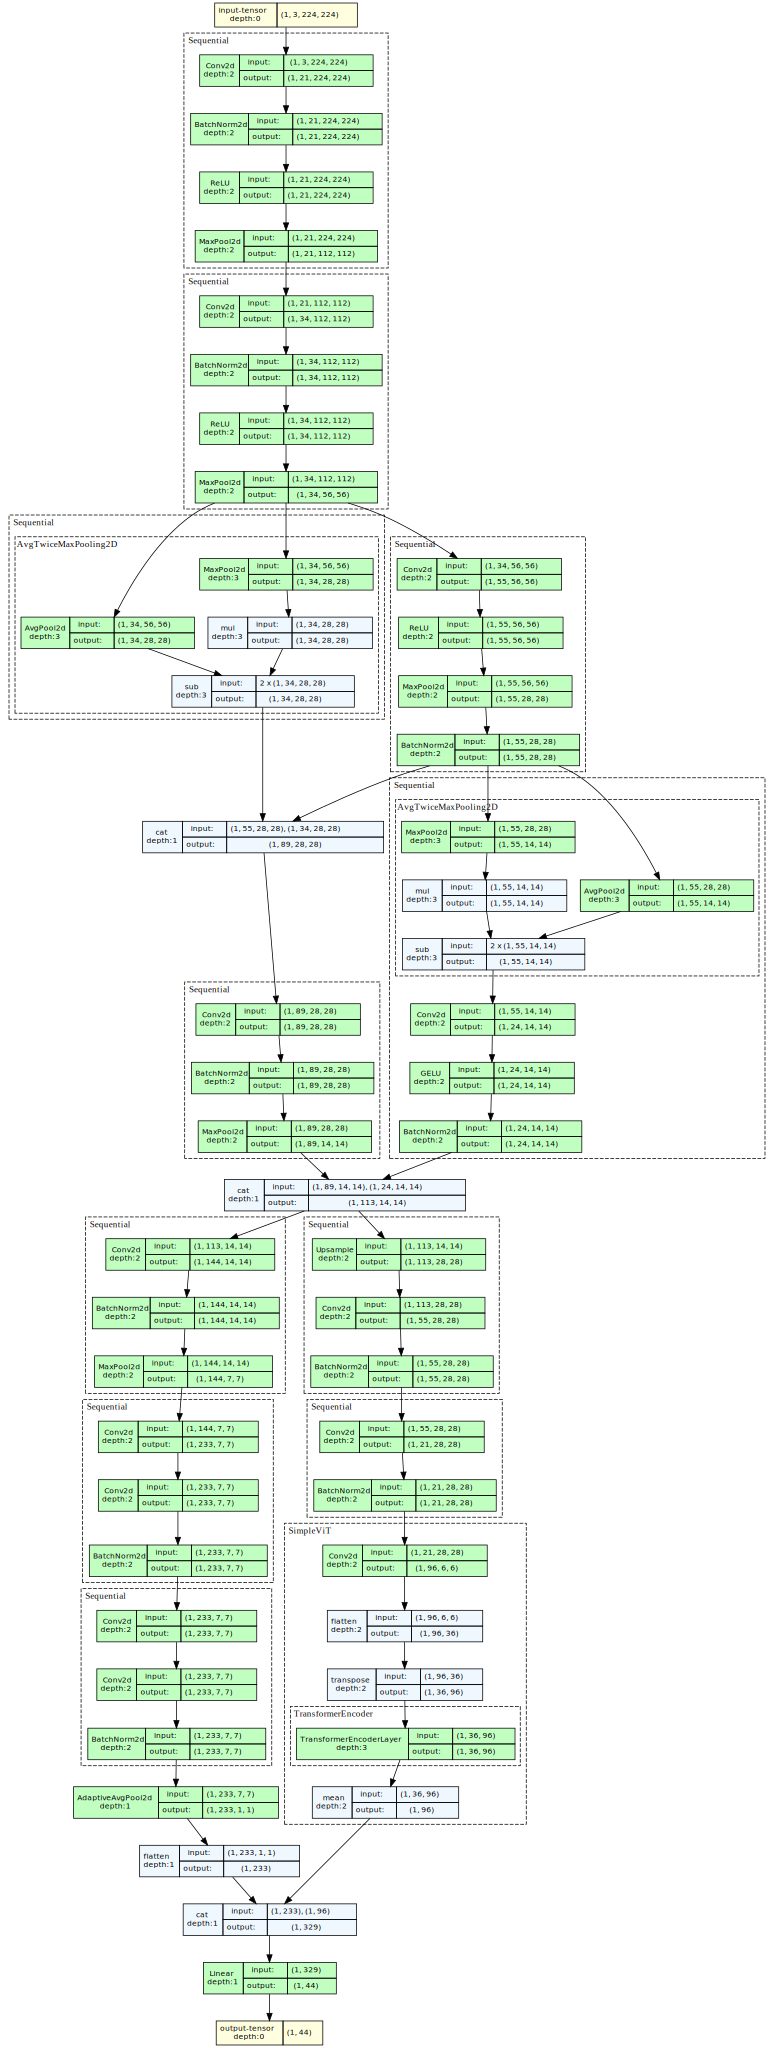

In [24]:


!pip install -q torchview graphviz
from torchview import draw_graph
from IPython.display import SVG, display

dummy = torch.randn(1, 3, 224, 224).to(device)

graph = draw_graph(
    model,
    input_data=dummy,
    expand_nested=True,
    graph_name="MRINet",
    save_graph=False
)

display(SVG(graph.visual_graph.pipe(format="svg")))


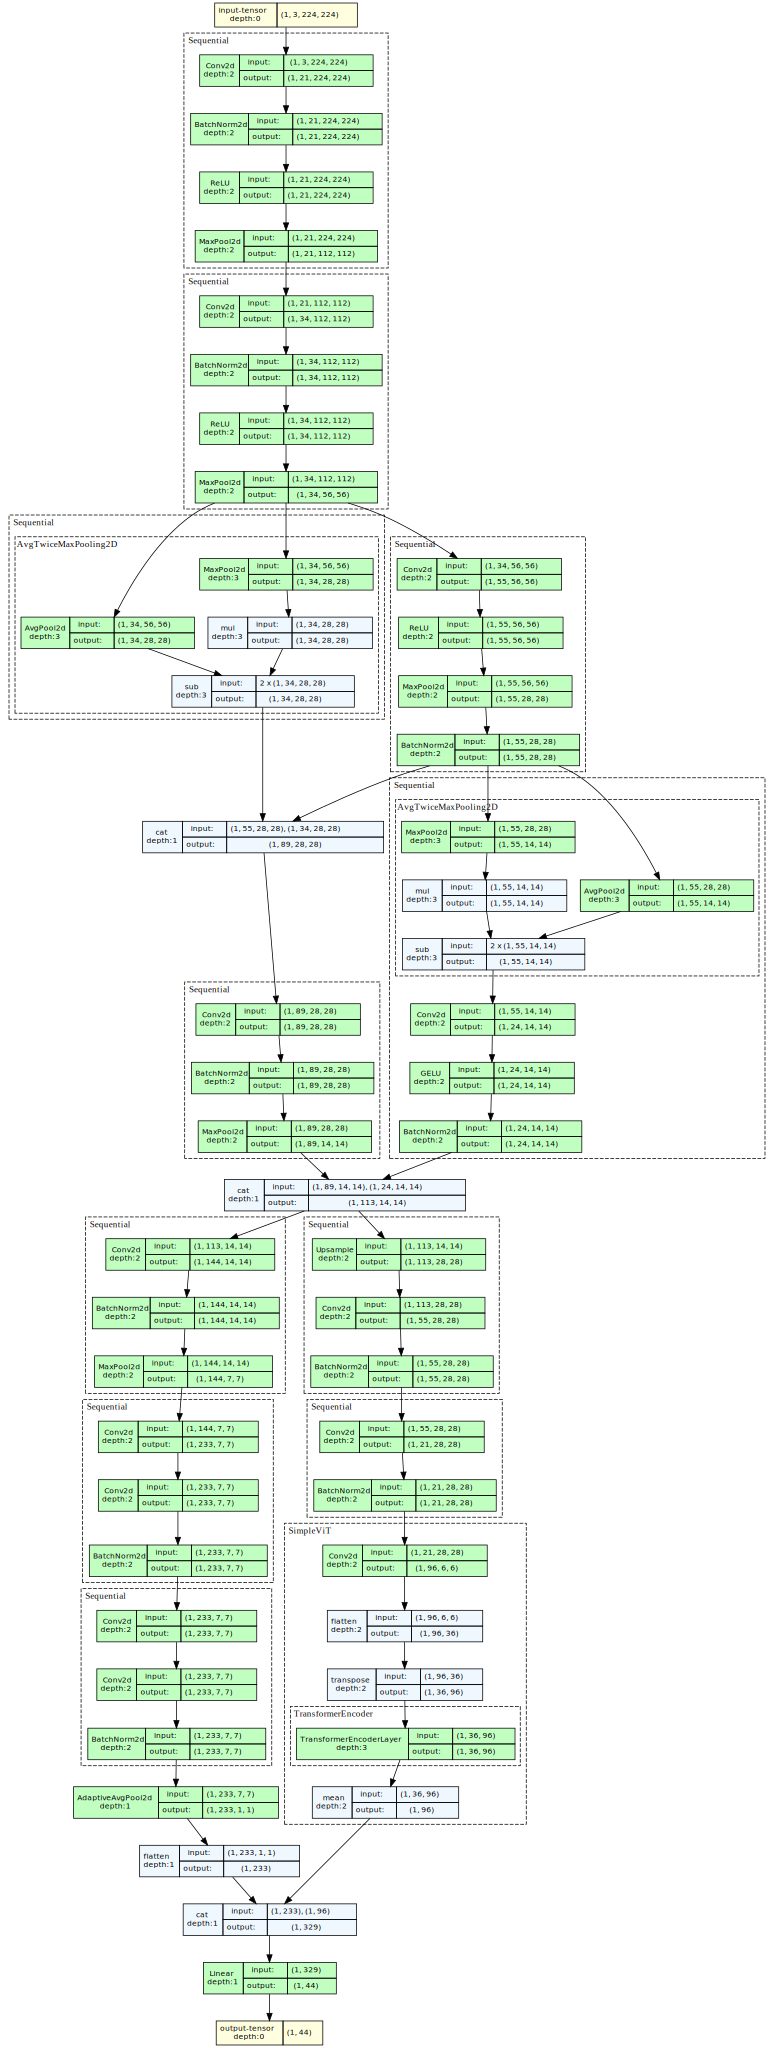

In [25]:
from torchview import draw_graph
from IPython.display import SVG, display

dummy_input = torch.randn(1, 3, 224, 224).to(device)

graph = draw_graph(
    model,
    input_data=dummy_input,
    expand_nested=True,
    graph_name="MRINet",
    save_graph=True,              # IMPORTANT
    filename="MRINet_BlockDiagram",
    directory="."
)

# Display inline
svg = graph.visual_graph.pipe(format="svg")
display(SVG(svg))


In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Fixed LR for first 15 epochs
warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda epoch: 1.0
)

adaptive_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=3,
    min_lr=1e-6
)



In [27]:

train_metrics = {
    "acc": MulticlassAccuracy(num_classes=num_classes).to(device),
    "precision": MulticlassPrecision(num_classes=num_classes, average="macro").to(device),
    "recall": MulticlassRecall(num_classes=num_classes, average="macro").to(device),
    "f1": MulticlassF1Score(num_classes=num_classes, average="macro").to(device),
    "auc": MulticlassAUROC(num_classes=num_classes).to(device),
    "mcc": MulticlassMatthewsCorrCoef(num_classes=num_classes).to(device)
}

val_metrics = {
    "acc": MulticlassAccuracy(num_classes=num_classes).to(device),
    "precision": MulticlassPrecision(num_classes=num_classes, average="macro").to(device),
    "recall": MulticlassRecall(num_classes=num_classes, average="macro").to(device),
    "f1": MulticlassF1Score(num_classes=num_classes, average="macro").to(device),
    "auc": MulticlassAUROC(num_classes=num_classes).to(device),
    "mcc": MulticlassMatthewsCorrCoef(num_classes=num_classes).to(device)
}

history = {
    "loss": [], "val_loss": [],
    "accuracy": [], "val_accuracy": [],
    "precision": [], "val_precision": [],
    "recall": [], "val_recall": [],
    "f1": [], "val_f1": [],
    "auc": [], "val_auc": [],
    "mcc": [], "val_mcc": [],
    "specificity": [], "val_specificity": [],
    "sensitivity": [], "val_sensitivity": []
}


In [28]:
import numpy as np
from sklearn.metrics import confusion_matrix

def multiclass_specificity_sensitivity(y_true, y_pred, num_classes):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

    specificity = []
    sensitivity = []

    for i in range(num_classes):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = cm.sum() - (tp + fp + fn)

        specificity.append(tn / (tn + fp + 1e-8))
        sensitivity.append(tp / (tp + fn + 1e-8))

    return float(np.mean(specificity)), float(np.mean(sensitivity))


In [29]:
EPOCHS = 40

for epoch in range(EPOCHS):

    # ================= TRAIN =================
    model.train()
    train_loss = 0.0
    train_preds, train_targets = [], []

    pbar = tqdm(
        train_loader,
        desc=f"Training Model - Epoch [{epoch+1}/{EPOCHS}]",
        leave=True
    )

    for x, y in pbar:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = out.argmax(dim=1)
        train_preds.append(preds.cpu())
        train_targets.append(y.cpu())

        for m in train_metrics.values():
            m.update(out, y)


    train_preds = torch.cat(train_preds).numpy()
    train_targets = torch.cat(train_targets).numpy()

    train_spec, train_sens = multiclass_specificity_sensitivity(
        train_targets, train_preds, num_classes
    )

    train_out = {k: v.compute().item() for k, v in train_metrics.items()}

    print(
        f"Metrics - loss: {train_loss/len(train_loader):.4f}, "
        f"accuracy: {train_out['acc']:.4f}, "
        f"precision: {train_out['precision']:.4f}, "
        f"recall: {train_out['recall']:.4f}, "
        f"f1_score: {train_out['f1']:.4f}, "
        f"specificity: {train_spec:.4f}, "
        f"sensitivity: {train_sens:.4f}, "
        f"mcc: {train_out['mcc']:.4f}, "
        f"auc: {train_out['auc']:.4f}"
    )
# ===== STORE TRAIN HISTORY =====
    history["loss"].append(train_loss / len(train_loader))
    history["accuracy"].append(train_out["acc"])
    history["precision"].append(train_out["precision"])
    history["recall"].append(train_out["recall"])
    history["f1"].append(train_out["f1"])
    history["auc"].append(train_out["auc"])
    history["mcc"].append(train_out["mcc"])
    history["specificity"].append(train_spec)
    history["sensitivity"].append(train_sens)

    for m in train_metrics.values():
        m.reset()

    # ================= VALID =================
    model.eval()
    val_loss = 0.0
    val_preds, val_targets = [], []

    pbar = tqdm(val_loader, desc="Validating Model", leave=True)

    with torch.no_grad():
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)

            val_loss += loss.item()
            preds = out.argmax(dim=1)

            val_preds.append(preds.cpu())
            val_targets.append(y.cpu())

            for m in val_metrics.values():
                m.update(out, y)

    val_preds = torch.cat(val_preds).numpy()
    val_targets = torch.cat(val_targets).numpy()

    val_spec, val_sens = multiclass_specificity_sensitivity(
        val_targets, val_preds, num_classes
    )

    val_out = {k: v.compute().item() for k, v in val_metrics.items()}
    # ================= SCHEDULER STEP =================
    if epoch < 15:
        warmup_scheduler.step()
    else:
        adaptive_scheduler.step(val_loss / len(val_loader))

    # Optional: print LR
    current_lr = optimizer.param_groups[0]["lr"]
    print(f"Current LR: {current_lr:.6e}")

    print(
        f"Metrics - loss: {val_loss/len(val_loader):.4f}, "
        f"accuracy: {val_out['acc']:.4f}, "
        f"precision: {val_out['precision']:.4f}, "
        f"recall: {val_out['recall']:.4f}, "
        f"f1_score: {val_out['f1']:.4f}, "
        f"specificity: {val_spec:.4f}, "
        f"sensitivity: {val_sens:.4f}, "
        f"mcc: {val_out['mcc']:.4f}, "
        f"auc: {val_out['auc']:.4f}"
    )
    # ===== STORE VALID HISTORY =====
    history["val_loss"].append(val_loss / len(val_loader))
    history["val_accuracy"].append(val_out["acc"])
    history["val_precision"].append(val_out["precision"])
    history["val_recall"].append(val_out["recall"])
    history["val_f1"].append(val_out["f1"])
    history["val_auc"].append(val_out["auc"])
    history["val_mcc"].append(val_out["mcc"])
    history["val_specificity"].append(val_spec)
    history["val_sensitivity"].append(val_sens)


    for m in val_metrics.values():
        m.reset()


Training Model - Epoch [1/40]: 100%|██████████| 180/180 [00:33<00:00,  5.34it/s]


Metrics - loss: 2.6894, accuracy: 0.1442, precision: 0.1525, recall: 0.1442, f1_score: 0.1273, specificity: 0.9828, sensitivity: 0.1442, mcc: 0.2456, auc: 0.8179


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.70it/s]


Current LR: 5.000000e-04
Metrics - loss: 2.6387, accuracy: 0.1688, precision: 0.1308, recall: 0.1688, f1_score: 0.1311, specificity: 0.9835, sensitivity: 0.1688, mcc: 0.2808, auc: 0.8757


Training Model - Epoch [2/40]: 100%|██████████| 180/180 [00:23<00:00,  7.81it/s]


Metrics - loss: 1.9750, accuracy: 0.2668, precision: 0.2986, recall: 0.2668, f1_score: 0.2563, specificity: 0.9870, sensitivity: 0.2668, mcc: 0.4295, auc: 0.9231


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.97it/s]


Current LR: 5.000000e-04
Metrics - loss: 2.2488, accuracy: 0.2693, precision: 0.3293, recall: 0.2693, f1_score: 0.2557, specificity: 0.9857, sensitivity: 0.2693, mcc: 0.3782, auc: 0.9113


Training Model - Epoch [3/40]: 100%|██████████| 180/180 [00:23<00:00,  7.81it/s]


Metrics - loss: 1.5655, accuracy: 0.3838, precision: 0.4734, recall: 0.3838, f1_score: 0.3895, specificity: 0.9896, sensitivity: 0.3838, mcc: 0.5413, auc: 0.9515


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.64it/s]


Current LR: 5.000000e-04
Metrics - loss: 2.0260, accuracy: 0.3032, precision: 0.3953, recall: 0.3032, f1_score: 0.2867, specificity: 0.9864, sensitivity: 0.3032, mcc: 0.4083, auc: 0.9458


Training Model - Epoch [4/40]: 100%|██████████| 180/180 [00:23<00:00,  7.69it/s]


Metrics - loss: 1.2787, accuracy: 0.4640, precision: 0.5472, recall: 0.4640, f1_score: 0.4736, specificity: 0.9914, sensitivity: 0.4640, mcc: 0.6205, auc: 0.9715


Validating Model: 100%|██████████| 45/45 [00:04<00:00,  9.36it/s]


Current LR: 5.000000e-04
Metrics - loss: 1.3983, accuracy: 0.4928, precision: 0.5958, recall: 0.4928, f1_score: 0.4894, specificity: 0.9908, sensitivity: 0.4928, mcc: 0.5953, auc: 0.9669


Training Model - Epoch [5/40]: 100%|██████████| 180/180 [00:23<00:00,  7.55it/s]


Metrics - loss: 1.0272, accuracy: 0.5580, precision: 0.6718, recall: 0.5580, f1_score: 0.5846, specificity: 0.9930, sensitivity: 0.5580, mcc: 0.6929, auc: 0.9804


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 11.02it/s]


Current LR: 5.000000e-04
Metrics - loss: 1.3519, accuracy: 0.4601, precision: 0.5953, recall: 0.4601, f1_score: 0.4788, specificity: 0.9906, sensitivity: 0.4601, mcc: 0.5978, auc: 0.9671


Training Model - Epoch [6/40]: 100%|██████████| 180/180 [00:23<00:00,  7.82it/s]


Metrics - loss: 0.8209, accuracy: 0.6445, precision: 0.7544, recall: 0.6445, f1_score: 0.6714, specificity: 0.9944, sensitivity: 0.6445, mcc: 0.7546, auc: 0.9899


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.74it/s]


Current LR: 5.000000e-04
Metrics - loss: 1.8312, accuracy: 0.3958, precision: 0.5575, recall: 0.3958, f1_score: 0.3873, specificity: 0.9890, sensitivity: 0.3958, mcc: 0.5241, auc: 0.9643


Training Model - Epoch [7/40]: 100%|██████████| 180/180 [00:22<00:00,  7.87it/s]


Metrics - loss: 0.7460, accuracy: 0.6876, precision: 0.7724, recall: 0.6876, f1_score: 0.7166, specificity: 0.9951, sensitivity: 0.6876, mcc: 0.7841, auc: 0.9915


Validating Model: 100%|██████████| 45/45 [00:04<00:00,  9.38it/s]


Current LR: 5.000000e-04
Metrics - loss: 0.9743, accuracy: 0.5589, precision: 0.7735, recall: 0.5589, f1_score: 0.5869, specificity: 0.9927, sensitivity: 0.5589, mcc: 0.6833, auc: 0.9868


Training Model - Epoch [8/40]: 100%|██████████| 180/180 [00:22<00:00,  7.90it/s]


Metrics - loss: 0.5300, accuracy: 0.7815, precision: 0.8430, recall: 0.7815, f1_score: 0.8053, specificity: 0.9966, sensitivity: 0.7815, mcc: 0.8485, auc: 0.9957


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.72it/s]


Current LR: 5.000000e-04
Metrics - loss: 1.0460, accuracy: 0.5858, precision: 0.7975, recall: 0.5858, f1_score: 0.6264, specificity: 0.9930, sensitivity: 0.5858, mcc: 0.6952, auc: 0.9824


Training Model - Epoch [9/40]: 100%|██████████| 180/180 [00:22<00:00,  7.85it/s]


Metrics - loss: 0.3961, accuracy: 0.8375, precision: 0.8981, recall: 0.8375, f1_score: 0.8620, specificity: 0.9975, sensitivity: 0.8375, mcc: 0.8903, auc: 0.9977


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.92it/s]


Current LR: 5.000000e-04
Metrics - loss: 0.9091, accuracy: 0.6473, precision: 0.8293, recall: 0.6473, f1_score: 0.6878, specificity: 0.9943, sensitivity: 0.6473, mcc: 0.7521, auc: 0.9833


Training Model - Epoch [10/40]: 100%|██████████| 180/180 [00:22<00:00,  7.83it/s]


Metrics - loss: 0.3252, accuracy: 0.8772, precision: 0.9077, recall: 0.8772, f1_score: 0.8905, specificity: 0.9980, sensitivity: 0.8772, mcc: 0.9139, auc: 0.9986


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.82it/s]


Current LR: 5.000000e-04
Metrics - loss: 0.6752, accuracy: 0.7311, precision: 0.8084, recall: 0.7311, f1_score: 0.7291, specificity: 0.9955, sensitivity: 0.7311, mcc: 0.8037, auc: 0.9902


Training Model - Epoch [11/40]: 100%|██████████| 180/180 [00:22<00:00,  7.84it/s]


Metrics - loss: 0.2188, accuracy: 0.9287, precision: 0.9477, recall: 0.9287, f1_score: 0.9370, specificity: 0.9989, sensitivity: 0.9287, mcc: 0.9506, auc: 0.9995


Validating Model: 100%|██████████| 45/45 [00:04<00:00,  9.27it/s]


Current LR: 5.000000e-04
Metrics - loss: 0.5800, accuracy: 0.7948, precision: 0.8502, recall: 0.7948, f1_score: 0.7933, specificity: 0.9965, sensitivity: 0.7948, mcc: 0.8442, auc: 0.9908


Training Model - Epoch [12/40]: 100%|██████████| 180/180 [00:22<00:00,  7.83it/s]


Metrics - loss: 0.1602, accuracy: 0.9631, precision: 0.9708, recall: 0.9631, f1_score: 0.9666, specificity: 0.9993, sensitivity: 0.9631, mcc: 0.9681, auc: 0.9998


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.86it/s]


Current LR: 5.000000e-04
Metrics - loss: 0.5588, accuracy: 0.7662, precision: 0.8779, recall: 0.7662, f1_score: 0.7834, specificity: 0.9961, sensitivity: 0.7662, mcc: 0.8314, auc: 0.9941


Training Model - Epoch [13/40]: 100%|██████████| 180/180 [00:22<00:00,  7.83it/s]


Metrics - loss: 0.1473, accuracy: 0.9578, precision: 0.9702, recall: 0.9578, f1_score: 0.9636, specificity: 0.9993, sensitivity: 0.9578, mcc: 0.9673, auc: 0.9997


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.84it/s]


Current LR: 5.000000e-04
Metrics - loss: 0.5890, accuracy: 0.8013, precision: 0.8405, recall: 0.8013, f1_score: 0.8026, specificity: 0.9961, sensitivity: 0.8013, mcc: 0.8310, auc: 0.9905


Training Model - Epoch [14/40]: 100%|██████████| 180/180 [00:23<00:00,  7.78it/s]


Metrics - loss: 0.1206, accuracy: 0.9760, precision: 0.9818, recall: 0.9760, f1_score: 0.9787, specificity: 0.9995, sensitivity: 0.9760, mcc: 0.9789, auc: 0.9999


Validating Model: 100%|██████████| 45/45 [00:04<00:00,  9.69it/s]


Current LR: 5.000000e-04
Metrics - loss: 0.8117, accuracy: 0.7708, precision: 0.8216, recall: 0.7708, f1_score: 0.7520, specificity: 0.9953, sensitivity: 0.7708, mcc: 0.7945, auc: 0.9874


Training Model - Epoch [15/40]: 100%|██████████| 180/180 [00:22<00:00,  8.02it/s]


Metrics - loss: 0.1235, accuracy: 0.9619, precision: 0.9710, recall: 0.9619, f1_score: 0.9657, specificity: 0.9993, sensitivity: 0.9619, mcc: 0.9713, auc: 0.9999


Validating Model: 100%|██████████| 45/45 [00:04<00:00,  9.28it/s]


Current LR: 5.000000e-04
Metrics - loss: 0.5531, accuracy: 0.8336, precision: 0.8460, recall: 0.8336, f1_score: 0.8186, specificity: 0.9966, sensitivity: 0.8336, mcc: 0.8500, auc: 0.9941


Training Model - Epoch [16/40]: 100%|██████████| 180/180 [00:22<00:00,  7.83it/s]


Metrics - loss: 0.1095, accuracy: 0.9734, precision: 0.9839, recall: 0.9734, f1_score: 0.9784, specificity: 0.9995, sensitivity: 0.9734, mcc: 0.9793, auc: 0.9999


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.58it/s]


Current LR: 5.000000e-04
Metrics - loss: 0.5527, accuracy: 0.8044, precision: 0.8771, recall: 0.8044, f1_score: 0.8175, specificity: 0.9968, sensitivity: 0.8044, mcc: 0.8597, auc: 0.9935


Training Model - Epoch [17/40]: 100%|██████████| 180/180 [00:22<00:00,  7.85it/s]


Metrics - loss: 0.1146, accuracy: 0.9708, precision: 0.9770, recall: 0.9708, f1_score: 0.9734, specificity: 0.9995, sensitivity: 0.9708, mcc: 0.9779, auc: 0.9999


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 11.07it/s]


Current LR: 5.000000e-04
Metrics - loss: 0.9935, accuracy: 0.7018, precision: 0.7893, recall: 0.7018, f1_score: 0.7170, specificity: 0.9945, sensitivity: 0.7018, mcc: 0.7607, auc: 0.9860


Training Model - Epoch [18/40]: 100%|██████████| 180/180 [00:23<00:00,  7.80it/s]


Metrics - loss: 0.2363, accuracy: 0.9146, precision: 0.9363, recall: 0.9146, f1_score: 0.9245, specificity: 0.9985, sensitivity: 0.9146, mcc: 0.9336, auc: 0.9994


Validating Model: 100%|██████████| 45/45 [00:04<00:00,  9.32it/s]


Current LR: 5.000000e-04
Metrics - loss: 0.5545, accuracy: 0.7788, precision: 0.8449, recall: 0.7788, f1_score: 0.7903, specificity: 0.9965, sensitivity: 0.7788, mcc: 0.8440, auc: 0.9913


Training Model - Epoch [19/40]: 100%|██████████| 180/180 [00:23<00:00,  7.80it/s]


Metrics - loss: 0.1071, accuracy: 0.9609, precision: 0.9730, recall: 0.9609, f1_score: 0.9661, specificity: 0.9994, sensitivity: 0.9609, mcc: 0.9728, auc: 0.9999


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.61it/s]


Current LR: 5.000000e-04
Metrics - loss: 0.4851, accuracy: 0.8276, precision: 0.8652, recall: 0.8276, f1_score: 0.8346, specificity: 0.9971, sensitivity: 0.8276, mcc: 0.8711, auc: 0.9943


Training Model - Epoch [20/40]: 100%|██████████| 180/180 [00:23<00:00,  7.78it/s]


Metrics - loss: 0.0809, accuracy: 0.9902, precision: 0.9918, recall: 0.9902, f1_score: 0.9909, specificity: 0.9997, sensitivity: 0.9902, mcc: 0.9887, auc: 0.9999


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.86it/s]


Current LR: 5.000000e-04
Metrics - loss: 0.7614, accuracy: 0.7682, precision: 0.8152, recall: 0.7682, f1_score: 0.7688, specificity: 0.9957, sensitivity: 0.7682, mcc: 0.8125, auc: 0.9904


Training Model - Epoch [21/40]: 100%|██████████| 180/180 [00:23<00:00,  7.81it/s]


Metrics - loss: 0.0888, accuracy: 0.9821, precision: 0.9834, recall: 0.9821, f1_score: 0.9825, specificity: 0.9996, sensitivity: 0.9821, mcc: 0.9833, auc: 0.9999


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.42it/s]


Current LR: 5.000000e-04
Metrics - loss: 0.4814, accuracy: 0.8357, precision: 0.8857, recall: 0.8357, f1_score: 0.8517, specificity: 0.9974, sensitivity: 0.8357, mcc: 0.8870, auc: 0.9948


Training Model - Epoch [22/40]: 100%|██████████| 180/180 [00:22<00:00,  7.92it/s]


Metrics - loss: 0.0568, accuracy: 0.9879, precision: 0.9923, recall: 0.9879, f1_score: 0.9899, specificity: 0.9998, sensitivity: 0.9879, mcc: 0.9917, auc: 1.0000


Validating Model: 100%|██████████| 45/45 [00:04<00:00,  9.29it/s]


Current LR: 5.000000e-04
Metrics - loss: 0.5456, accuracy: 0.8236, precision: 0.8634, recall: 0.8236, f1_score: 0.8252, specificity: 0.9969, sensitivity: 0.8236, mcc: 0.8656, auc: 0.9957


Training Model - Epoch [23/40]: 100%|██████████| 180/180 [00:23<00:00,  7.80it/s]


Metrics - loss: 0.2095, accuracy: 0.9405, precision: 0.9485, recall: 0.9405, f1_score: 0.9439, specificity: 0.9987, sensitivity: 0.9405, mcc: 0.9441, auc: 0.9995


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.61it/s]


Current LR: 5.000000e-04
Metrics - loss: 1.3753, accuracy: 0.6676, precision: 0.7627, recall: 0.6676, f1_score: 0.6731, specificity: 0.9937, sensitivity: 0.6676, mcc: 0.7285, auc: 0.9900


Training Model - Epoch [24/40]: 100%|██████████| 180/180 [00:23<00:00,  7.82it/s]


Metrics - loss: 0.2935, accuracy: 0.8987, precision: 0.9124, recall: 0.8987, f1_score: 0.9043, specificity: 0.9982, sensitivity: 0.8987, mcc: 0.9187, auc: 0.9988


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 11.00it/s]


Current LR: 5.000000e-04
Metrics - loss: 0.5487, accuracy: 0.8070, precision: 0.8464, recall: 0.8070, f1_score: 0.8107, specificity: 0.9965, sensitivity: 0.8070, mcc: 0.8467, auc: 0.9953


Training Model - Epoch [25/40]: 100%|██████████| 180/180 [00:23<00:00,  7.74it/s]


Metrics - loss: 0.1028, accuracy: 0.9788, precision: 0.9774, recall: 0.9788, f1_score: 0.9779, specificity: 0.9995, sensitivity: 0.9788, mcc: 0.9760, auc: 0.9999


Validating Model: 100%|██████████| 45/45 [00:04<00:00,  9.35it/s]


Current LR: 2.500000e-04
Metrics - loss: 0.6388, accuracy: 0.7975, precision: 0.8772, recall: 0.7975, f1_score: 0.8183, specificity: 0.9966, sensitivity: 0.7975, mcc: 0.8515, auc: 0.9935


Training Model - Epoch [26/40]: 100%|██████████| 180/180 [00:22<00:00,  7.89it/s]


Metrics - loss: 0.0519, accuracy: 0.9910, precision: 0.9947, recall: 0.9910, f1_score: 0.9927, specificity: 0.9998, sensitivity: 0.9910, mcc: 0.9931, auc: 1.0000


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.20it/s]


Current LR: 2.500000e-04
Metrics - loss: 0.3970, accuracy: 0.8484, precision: 0.8876, recall: 0.8484, f1_score: 0.8580, specificity: 0.9978, sensitivity: 0.8484, mcc: 0.9015, auc: 0.9966


Training Model - Epoch [27/40]: 100%|██████████| 180/180 [00:23<00:00,  7.82it/s]


Metrics - loss: 0.0408, accuracy: 0.9990, precision: 0.9980, recall: 0.9990, f1_score: 0.9985, specificity: 1.0000, sensitivity: 0.9990, mcc: 0.9982, auc: 1.0000


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.73it/s]


Current LR: 2.500000e-04
Metrics - loss: 0.3403, accuracy: 0.8746, precision: 0.9040, recall: 0.8746, f1_score: 0.8816, specificity: 0.9982, sensitivity: 0.8746, mcc: 0.9203, auc: 0.9971


Training Model - Epoch [28/40]: 100%|██████████| 180/180 [00:23<00:00,  7.73it/s]


Metrics - loss: 0.0405, accuracy: 0.9991, precision: 0.9994, recall: 0.9991, f1_score: 0.9992, specificity: 1.0000, sensitivity: 0.9991, mcc: 0.9985, auc: 1.0000


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.69it/s]


Current LR: 2.500000e-04
Metrics - loss: 0.3594, accuracy: 0.8711, precision: 0.9078, recall: 0.8711, f1_score: 0.8830, specificity: 0.9980, sensitivity: 0.8711, mcc: 0.9131, auc: 0.9969


Training Model - Epoch [29/40]: 100%|██████████| 180/180 [00:23<00:00,  7.75it/s]


Metrics - loss: 0.0364, accuracy: 0.9989, precision: 0.9991, recall: 0.9989, f1_score: 0.9990, specificity: 0.9999, sensitivity: 0.9989, mcc: 0.9971, auc: 1.0000


Validating Model: 100%|██████████| 45/45 [00:04<00:00,  9.22it/s]


Current LR: 2.500000e-04
Metrics - loss: 0.4161, accuracy: 0.8483, precision: 0.9025, recall: 0.8483, f1_score: 0.8649, specificity: 0.9978, sensitivity: 0.8483, mcc: 0.9030, auc: 0.9956


Training Model - Epoch [30/40]: 100%|██████████| 180/180 [00:23<00:00,  7.78it/s]


Metrics - loss: 0.0399, accuracy: 0.9977, precision: 0.9964, recall: 0.9977, f1_score: 0.9970, specificity: 0.9999, sensitivity: 0.9977, mcc: 0.9953, auc: 1.0000


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.73it/s]


Current LR: 2.500000e-04
Metrics - loss: 0.4952, accuracy: 0.8387, precision: 0.8928, recall: 0.8387, f1_score: 0.8535, specificity: 0.9973, sensitivity: 0.8387, mcc: 0.8812, auc: 0.9945


Training Model - Epoch [31/40]: 100%|██████████| 180/180 [00:23<00:00,  7.79it/s]


Metrics - loss: 0.0688, accuracy: 0.9878, precision: 0.9924, recall: 0.9878, f1_score: 0.9900, specificity: 0.9997, sensitivity: 0.9878, mcc: 0.9887, auc: 0.9999


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.84it/s]


Current LR: 1.250000e-04
Metrics - loss: 0.3863, accuracy: 0.8670, precision: 0.9051, recall: 0.8670, f1_score: 0.8730, specificity: 0.9979, sensitivity: 0.8670, mcc: 0.9073, auc: 0.9960


Training Model - Epoch [32/40]: 100%|██████████| 180/180 [00:23<00:00,  7.80it/s]


Metrics - loss: 0.0425, accuracy: 0.9970, precision: 0.9991, recall: 0.9970, f1_score: 0.9980, specificity: 0.9999, sensitivity: 0.9970, mcc: 0.9975, auc: 1.0000


Validating Model: 100%|██████████| 45/45 [00:04<00:00,  9.34it/s]


Current LR: 1.250000e-04
Metrics - loss: 0.3937, accuracy: 0.8597, precision: 0.8968, recall: 0.8597, f1_score: 0.8702, specificity: 0.9978, sensitivity: 0.8597, mcc: 0.9044, auc: 0.9963


Training Model - Epoch [33/40]: 100%|██████████| 180/180 [00:22<00:00,  7.89it/s]


Metrics - loss: 0.0379, accuracy: 0.9993, precision: 0.9991, recall: 0.9993, f1_score: 0.9992, specificity: 1.0000, sensitivity: 0.9993, mcc: 0.9982, auc: 1.0000


Validating Model: 100%|██████████| 45/45 [00:04<00:00,  9.85it/s]


Current LR: 1.250000e-04
Metrics - loss: 0.3822, accuracy: 0.8705, precision: 0.8807, recall: 0.8705, f1_score: 0.8681, specificity: 0.9978, sensitivity: 0.8705, mcc: 0.9044, auc: 0.9964


Training Model - Epoch [34/40]: 100%|██████████| 180/180 [00:23<00:00,  7.78it/s]


Metrics - loss: 0.0311, accuracy: 0.9995, precision: 0.9996, recall: 0.9995, f1_score: 0.9995, specificity: 1.0000, sensitivity: 0.9995, mcc: 0.9985, auc: 1.0000


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.92it/s]


Current LR: 1.250000e-04
Metrics - loss: 0.3722, accuracy: 0.8677, precision: 0.8926, recall: 0.8677, f1_score: 0.8708, specificity: 0.9980, sensitivity: 0.8677, mcc: 0.9117, auc: 0.9965


Training Model - Epoch [35/40]: 100%|██████████| 180/180 [00:23<00:00,  7.77it/s]


Metrics - loss: 0.0322, accuracy: 0.9987, precision: 0.9989, recall: 0.9987, f1_score: 0.9988, specificity: 0.9999, sensitivity: 0.9987, mcc: 0.9975, auc: 1.0000


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.87it/s]


Current LR: 6.250000e-05
Metrics - loss: 0.3720, accuracy: 0.8583, precision: 0.8963, recall: 0.8583, f1_score: 0.8687, specificity: 0.9979, sensitivity: 0.8583, mcc: 0.9073, auc: 0.9959


Training Model - Epoch [36/40]: 100%|██████████| 180/180 [00:23<00:00,  7.80it/s]


Metrics - loss: 0.0337, accuracy: 0.9988, precision: 0.9995, recall: 0.9988, f1_score: 0.9991, specificity: 1.0000, sensitivity: 0.9988, mcc: 0.9982, auc: 1.0000


Validating Model: 100%|██████████| 45/45 [00:04<00:00,  9.25it/s]


Current LR: 6.250000e-05
Metrics - loss: 0.3626, accuracy: 0.8742, precision: 0.9254, recall: 0.8742, f1_score: 0.8871, specificity: 0.9981, sensitivity: 0.8742, mcc: 0.9175, auc: 0.9960


Training Model - Epoch [37/40]: 100%|██████████| 180/180 [00:23<00:00,  7.78it/s]


Metrics - loss: 0.0300, accuracy: 0.9993, precision: 0.9995, recall: 0.9993, f1_score: 0.9994, specificity: 1.0000, sensitivity: 0.9993, mcc: 0.9985, auc: 1.0000


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.90it/s]


Current LR: 6.250000e-05
Metrics - loss: 0.3575, accuracy: 0.8738, precision: 0.8999, recall: 0.8738, f1_score: 0.8805, specificity: 0.9981, sensitivity: 0.8738, mcc: 0.9174, auc: 0.9956


Training Model - Epoch [38/40]: 100%|██████████| 180/180 [00:23<00:00,  7.82it/s]


Metrics - loss: 0.0232, accuracy: 0.9995, precision: 0.9995, recall: 0.9995, f1_score: 0.9995, specificity: 1.0000, sensitivity: 0.9995, mcc: 0.9985, auc: 1.0000


Validating Model: 100%|██████████| 45/45 [00:04<00:00, 10.91it/s]


Current LR: 6.250000e-05
Metrics - loss: 0.3802, accuracy: 0.8641, precision: 0.8959, recall: 0.8641, f1_score: 0.8699, specificity: 0.9980, sensitivity: 0.8641, mcc: 0.9117, auc: 0.9956


Training Model - Epoch [39/40]: 100%|██████████| 180/180 [00:23<00:00,  7.82it/s]


Metrics - loss: 0.0315, accuracy: 0.9992, precision: 0.9995, recall: 0.9992, f1_score: 0.9993, specificity: 1.0000, sensitivity: 0.9992, mcc: 0.9982, auc: 1.0000


Validating Model: 100%|██████████| 45/45 [00:04<00:00,  9.93it/s]


Current LR: 3.125000e-05
Metrics - loss: 0.3725, accuracy: 0.8759, precision: 0.9195, recall: 0.8759, f1_score: 0.8883, specificity: 0.9981, sensitivity: 0.8759, mcc: 0.9189, auc: 0.9957


Training Model - Epoch [40/40]: 100%|██████████| 180/180 [00:22<00:00,  7.94it/s]


Metrics - loss: 0.0187, accuracy: 0.9996, precision: 0.9997, recall: 0.9996, f1_score: 0.9996, specificity: 1.0000, sensitivity: 0.9996, mcc: 0.9989, auc: 1.0000


Validating Model: 100%|██████████| 45/45 [00:04<00:00,  9.24it/s]

Current LR: 3.125000e-05
Metrics - loss: 0.3569, accuracy: 0.8809, precision: 0.9006, recall: 0.8809, f1_score: 0.8854, specificity: 0.9981, sensitivity: 0.8809, mcc: 0.9174, auc: 0.9962


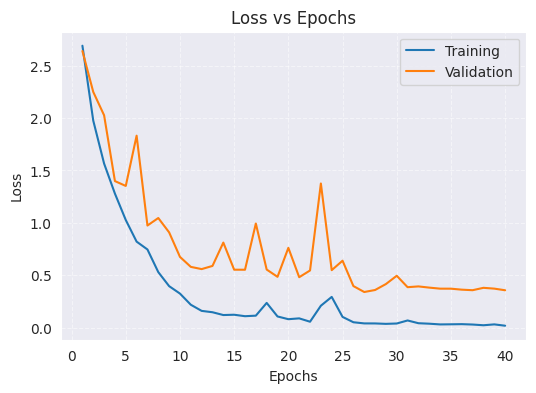

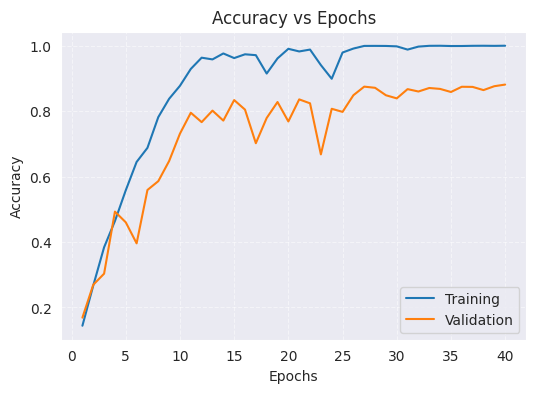

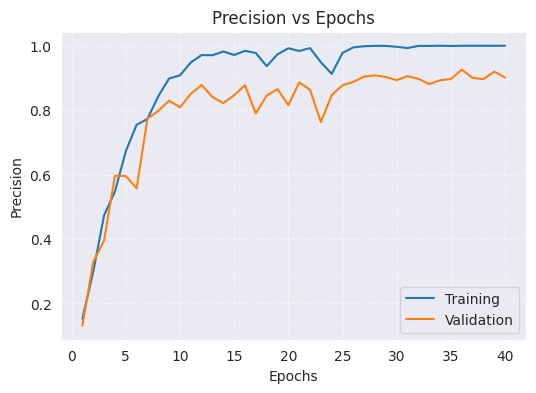

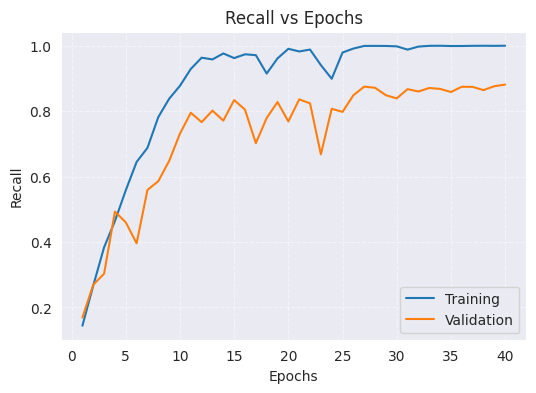

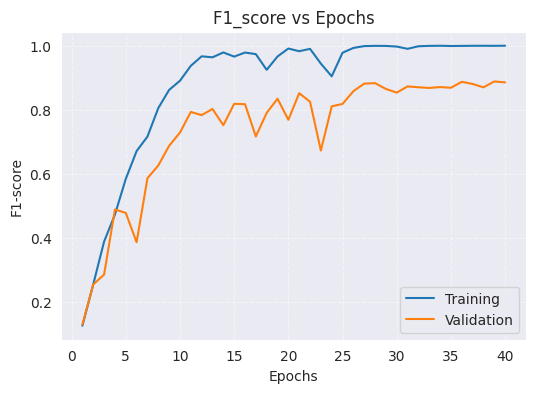

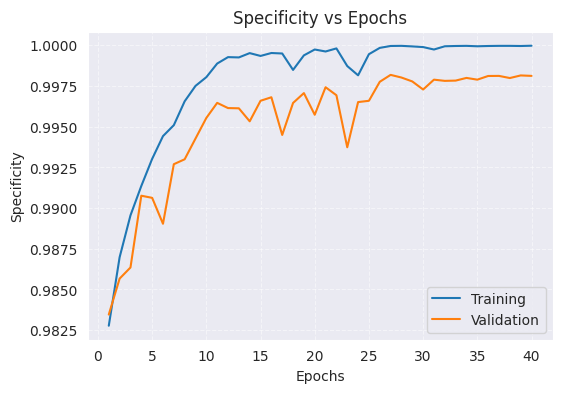

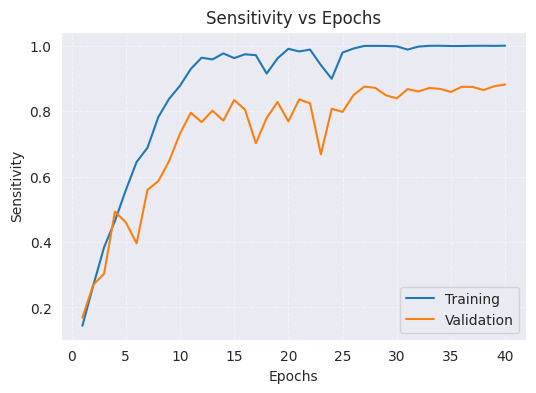

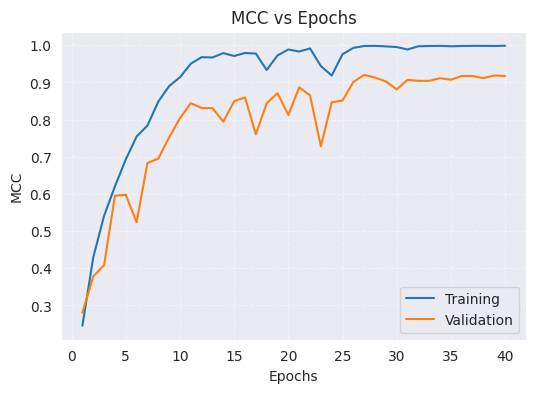

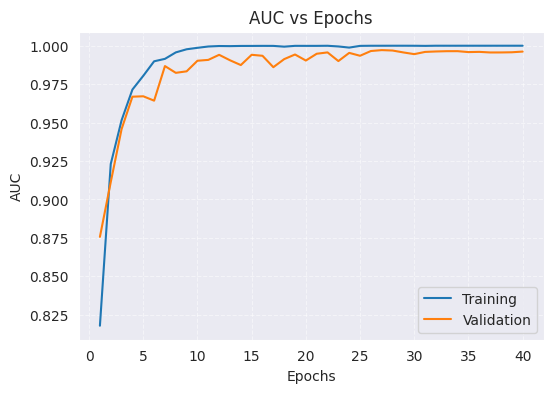

In [30]:
def plot_metric(train, val, title, ylabel):
    epochs = range(1, len(train) + 1)
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, train, label="Training")
    plt.plot(epochs, val, label="Validation")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


plot_metric(history["loss"], history["val_loss"], "Loss vs Epochs", "Loss")
plot_metric(history["accuracy"], history["val_accuracy"], "Accuracy vs Epochs", "Accuracy")
plot_metric(history["precision"], history["val_precision"], "Precision vs Epochs", "Precision")
plot_metric(history["recall"], history["val_recall"], "Recall vs Epochs", "Recall")
plot_metric(history["f1"], history["val_f1"], "F1_score vs Epochs", "F1-score")
plot_metric(history["specificity"], history["val_specificity"], "Specificity vs Epochs", "Specificity")
plot_metric(history["sensitivity"], history["val_sensitivity"], "Sensitivity vs Epochs", "Sensitivity")
plot_metric(history["mcc"], history["val_mcc"], "MCC vs Epochs", "MCC")
plot_metric(history["auc"], history["val_auc"], "AUC vs Epochs", "AUC")


In [31]:
model.eval()
test_metrics = {k: v.clone().to(device) for k, v in train_metrics.items()}
test_loss = 0.0
all_preds, all_targets = [], []

with torch.no_grad():
    pbar = tqdm(test_loader, desc="Testing Model")
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)
        test_loss += loss.item()

        preds = out.argmax(dim=1)
        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())

        for m in test_metrics.values():
            m.update(out, y)

all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

test_spec, test_sens = multiclass_specificity_sensitivity(
    all_targets, all_preds, num_classes
)

print(
    f"Metrics - loss: {test_loss/len(test_loader):.4f}, "
    f"accuracy: {test_metrics['acc'].compute().item():.4f}, "
    f"precision: {test_metrics['precision'].compute().item():.4f}, "
    f"recall: {test_metrics['recall'].compute().item():.4f}, "
    f"f1_score: {test_metrics['f1'].compute().item():.4f}, "
    f"specificity: {test_spec:.4f}, "
    f"sensitivity: {test_sens:.4f}, "
    f"mcc: {test_metrics['mcc'].compute().item():.4f}, "
    f"auc: {test_metrics['auc'].compute().item():.4f}"
)


Testing Model: 100%|██████████| 56/56 [00:11<00:00,  5.07it/s]

Metrics - loss: 0.3782, accuracy: 0.8645, precision: 0.8708, recall: 0.8645, f1_score: 0.8637, specificity: 0.9977, sensitivity: 0.8645, mcc: 0.8980, auc: 0.9970


In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class_names = [idx_to_class[i] for i in range(num_classes)]



# -------- CLASSIFICATION REPORT --------
print("\nClassification Report (Test Set):\n")

report = classification_report(
    all_targets,
    all_preds,
    target_names=class_names,
    digits=4,
    zero_division=0
)
print(report)



Classification Report (Test Set):

                        precision    recall  f1-score   support

        Astrocitoma T1     0.8649    0.9143    0.8889        35
      Astrocitoma T1C+     0.9756    0.8696    0.9195        46
        Astrocitoma T2     0.8387    0.7647    0.8000        34
          Carcinoma T1     1.0000    1.0000    1.0000        13
        Carcinoma T1C+     1.0000    0.9545    0.9767        22
          Carcinoma T2     0.8235    0.9333    0.8750        15
         Ependimoma T1     1.0000    1.0000    1.0000         9
       Ependimoma T1C+     0.9000    0.9000    0.9000        10
         Ependimoma T2     0.8889    0.7273    0.8000        11
      Ganglioglioma T1     1.0000    1.0000    1.0000         4
    Ganglioglioma T1C+     1.0000    0.6667    0.8000         3
      Ganglioglioma T2     0.6000    0.6000    0.6000         5
          Germinoma T1     1.0000    1.0000    1.0000         5
        Germinoma T1C+     1.0000    0.8750    0.9333         8
   

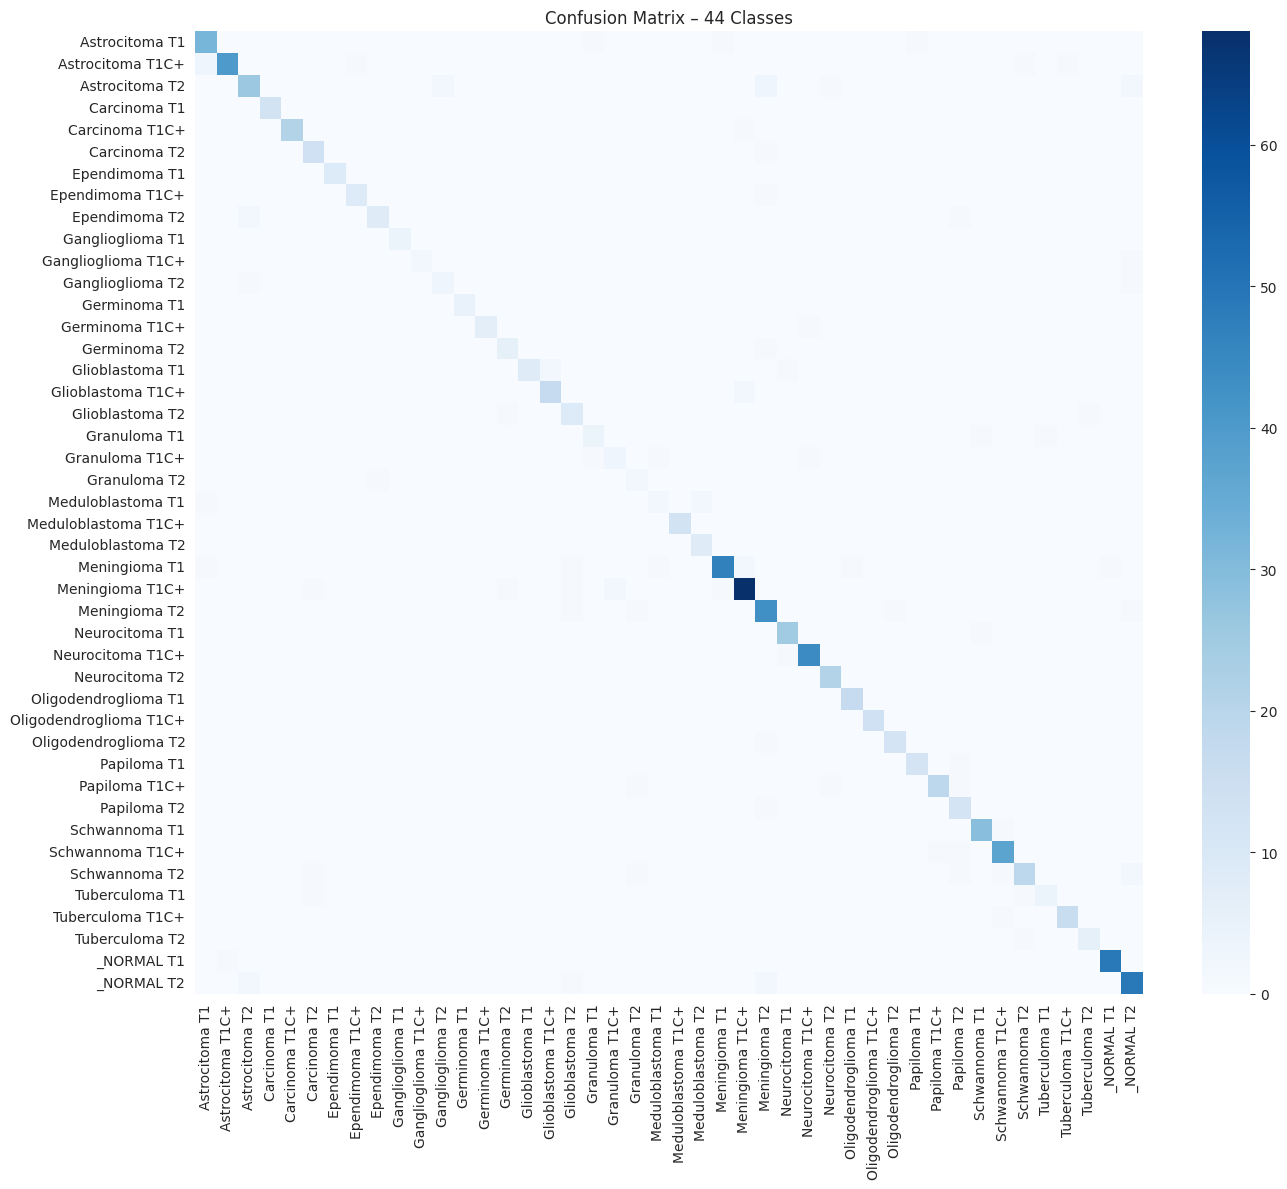

In [33]:
cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm,
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Confusion Matrix – 44 Classes")
plt.tight_layout()
plt.show()
